<a href="https://colab.research.google.com/github/marketakvasova/LSEC_segmentation/blob/main/semiautomatic_cell_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on: https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

# Semiautomatic segmentation of cells in images

# Setup

In [ ]:
!pip install -q jupyter_bbox_widget

import torch
import torchvision
# print("PyTorch version:", torch.__version__)
# print("Torchvision version:", torchvision.__version__)
# print("CUDA is available:", torch.cuda.is_available())
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import base64
import os
import glob
from google.colab import drive
from google.colab.patches import cv2_imshow
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets

output.enable_custom_widget_manager()

!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.9 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ux_g7ne4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ux_g7ne4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=24491d897bcae9742f8b39d623274c3e68a29ef0da4332897b302be0fe6c673f
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7e11cr9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-09 16:06:03--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbai

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def gray2rgb(image):
    if len(image.shape) == 2:
        image = np.repeat(image[:, :, None], 3, axis=-1)
    return image

def rescale_and_encode(image, scale):
    h, w = image.shape
    # print(h, w)
    # Define the new dimensions
    new_width = int(w/scale)
    new_height = int(h/scale)
    # print(new_height, new_width)
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))
    resized_image = gray2rgb(resized_image)
    # cv2_imshow(resized_image)

    # Convert the resized image to JPEG format
    _, encoded_image = cv2.imencode('.jpg', resized_image)

    # Convert the encoded image data to Base64 string
    base64_encoded_image = "data:image/jpg;base64,"+str(base64.b64encode(encoded_image), 'utf-8')
    return base64_encoded_image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# image_path = "./gdrive/MyDrive/lsec_test/old11_CA150_NW_03.tif"
# image = cv2.imread(image_path)
# if len(image.shape) == 2:
#     image = np.repeat(image[:, :, None], 3, axis=-1)
# # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

Mounted at /content/gdrive


In [ ]:


# sam_checkpoint = "sam_vit_h_4b8939.pth"
# model_type = "vit_h"
model_type = 'vit_b'
sam_checkpoint = 'sam_vit_b_01ec64.pth'

if torch.cuda.is_available():
    device = "cuda"
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
else:
    print("Connect to GPU under 'Edit'->'Notebook Settings'->'Hardware accelerator'.")

In [ ]:
path = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"
IMAGE_PATH = "./gdrive/MyDrive/ROIs_manually_corrected/train_images/old11_CA150_NE_03.tif"
out_path = "./gdrive/MyDrive/ROIs_manually_corrected/train_images"


image_names = os.listdir(path)

# Filter out only the PNG files
# image_names = [file for file in all_files if file.endswith('.png')]

annotations = {}

In [ ]:
# from IPython.display import clear_output
# import seaborn as sns
# from IPython.display import Image
# PLOTTED = False
import cv2
import numpy as np
from skimage.measure import label

def get_points(bboxes, scale):
    num_points = len(bboxes)
    # input_points1 = np.empty((num_points, 2))
    # input_labels1 = np.empty((len(widget.bboxes)))
    input_points1 = []
    input_labels1 = []
    input_points2 = []
    input_labels2 = []
    for i in range(len(bboxes)):
        x = bboxes[i]['x']*scale
        y = bboxes[i]['y']*scale
        label = bboxes[i]['label']
        if label == 'cell_inside':
            input_points1.append([x, y])
            input_labels1.append(1)
            input_points2.append([x, y])
            input_labels2.append(0)
        elif label == 'cell_outside':
            input_points1.append([x, y])
            input_labels1.append(0)
            input_points2.append([x, y])
            input_labels2.append(0)
        elif label == 'nucleus':
            input_points2.append([x, y])
            input_labels2.append(1)
    input_points1 = np.array(input_points1)
    input_points2 = np.array(input_points2)
    input_labels1 = np.array(input_labels1)
    input_labels2 = np.array(input_labels2)
    return input_points1, input_points2, input_labels1, input_labels2


def run_sam_on_points(image, input_points, input_labels, case):
    if case == 'cell':
        multimask = [True, True, False]
    else:
        multimask = [True, False, False]
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        # mask_input=mask_input[None, :, :],
        multimask_output=multimask[0],
    )
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        mask_input=mask_input[None, :, :],
        multimask_output=multimask[1],
    )
    mask_input = logits[np.argmax(scores), :, :]
    mask1, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        mask_input=mask_input[None, :, :],
        multimask_output=multimask[2],
    )
    return mask1

def run_sam(image, bboxes, scale):
    input_points1, input_points2, input_labels1, input_labels2 = get_points(bboxes, scale)
    cell_mask = run_sam_on_points(image, input_points1, input_labels1, 'cell')
    nucleus_mask = run_sam_on_points(image, input_points2, input_labels2, 'nucleus')

    mask = cell_mask ^ nucleus_mask


    # masks, scores, logits = predictor.predict(
    #     point_coords=input_points1,
    #     point_labels=input_labels1,
    #     # mask_input=mask_input[None, :, :],
    #     multimask_output=True,
    # )
    # mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    # masks, scores, logits = predictor.predict(
    #     point_coords=input_points1,
    #     point_labels=input_labels1,
    #     mask_input=mask_input[None, :, :],
    #     multimask_output=True,
    # )
    # mask_input = logits[np.argmax(scores), :, :]
    # mask1, scores, logits = predictor.predict(
    #     point_coords=input_points1,
    #     point_labels=input_labels1,
    #     mask_input=mask_input[None, :, :],
    #     multimask_output=False,
    # )

    # masks, scores, logits = predictor.predict(
    # point_coords=input_points2,
    # point_labels=input_labels2,
    # # mask_input=mask_input[None, :, :],
    # multimask_output=True,
    # )
    # mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    # masks, scores, logits = predictor.predict(
    #     point_coords=input_points2,
    #     point_labels=input_labels2,
    #     mask_input=mask_input[None, :, :],
    #     multimask_output=False,
    # )
    # mask_input = logits[np.argmax(scores), :, :]
    # masks, scores, logits = predictor.predict(
    #     point_coords=input_points2,
    #     point_labels=input_labels2,
    #     mask_input=mask_input[None, :, :],
    #     multimask_output=False,
    # )
    # plt.close('all')


    # plt.imshow(image)
    # show_mask(mask, plt.gca())
    # show_points(input_points2, input_labels2, plt.gca())
    # plt.axis('off')
    # plt.show(block=False)





    plt.figure(figsize=(10,10))
    plt.imshow(image)
    # print(image.shape)
    show_mask(mask, plt.gca())
    show_points(input_points2, 1-input_labels2, plt.gca())
    show_points(input_points1, input_labels1, plt.gca())
    plt.axis('off')
    plt.show()
    return mask.squeeze().astype(np.uint8)*255

    # plt.figure(figsize=(10,10))
    # plt.imshow(image)
    # # print(image.shape)
    # show_mask(convex_mask, plt.gca())
    # show_points(input_points1, input_labels1, plt.gca())
    # plt.axis('off')
    # plt.show()


In [ ]:
w_progress = widgets.IntProgress(value=0, max=len(image_names), description='Progress')

scale = 8
image = cv2.imread(os.path.join(path, image_names[0]), cv2.IMREAD_GRAYSCALE)
image_encoded = rescale_and_encode(image, scale)

w_bbox = BBoxWidget(
    image = image_encoded,
    classes=['nucleus', 'cell_inside', 'cell_outside']
)

# combine widgets into a container
w_container = widgets.VBox([
    w_progress,
    w_bbox,
])

# when Skip button is pressed we move on to the next file
@w_bbox.on_skip
def skip():
    w_progress.value += 1
    # open new image in the widget
    if w_progress.value < len(image_names):
        image_file = image_names[w_progress.value]
        image = cv2.imread(os.path.join(path, image_names[w_progress.value]), cv2.IMREAD_GRAYSCALE)
        w_bbox.image = rescale_and_encode(image, scale)
        # here we assign an empty list to bboxes but
        # we could also run a detection model on the file
        # and use its output for creating inital bboxes
        w_bbox.bboxes = []

# when Submit button is pressed we save current annotations
# and then move on to the next file

@w_bbox.on_submit
def submit():
    if w_progress.value < len(image_names):
        image_file = image_names[w_progress.value]
        # save annotations for current image
        annotations[image_file] = w_bbox.bboxes
        image = cv2.imread(os.path.join(path, image_names[w_progress.value]), cv2.IMREAD_GRAYSCALE)
        mask = run_sam(gray2rgb(image), w_bbox.bboxes, scale)
        cv2.imwrite(os.path.join(out_path, 'mask_'+image_file), mask)
        # with open(annotations_path, 'w') as f:
        #     json.dump(annotations, f, indent=4)
        # move on to the next file
        # skip()

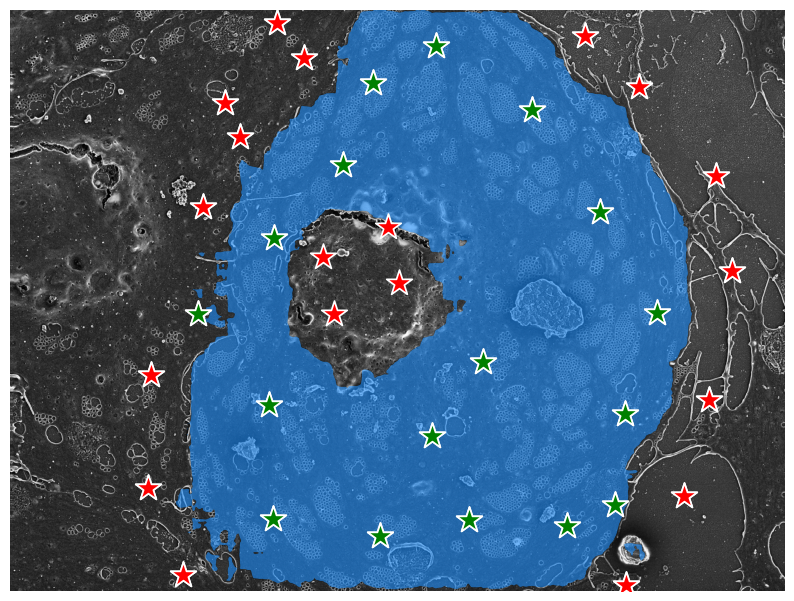

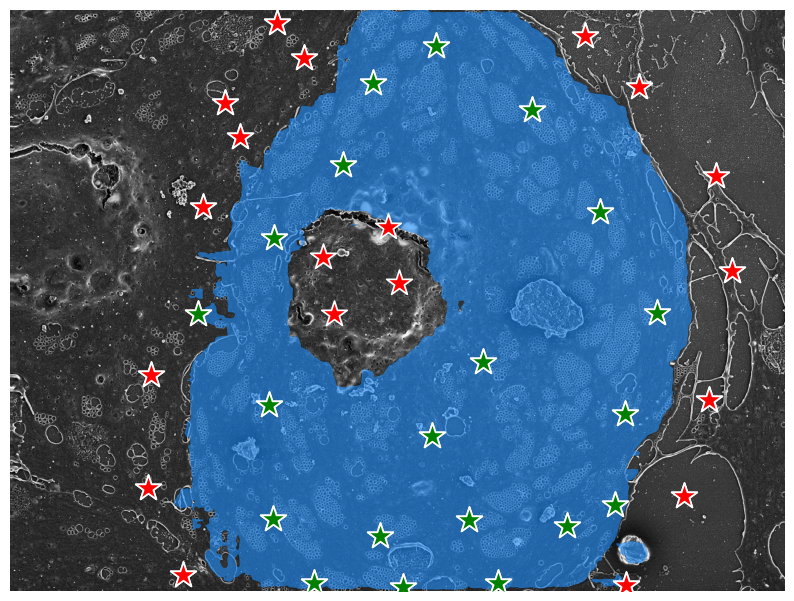

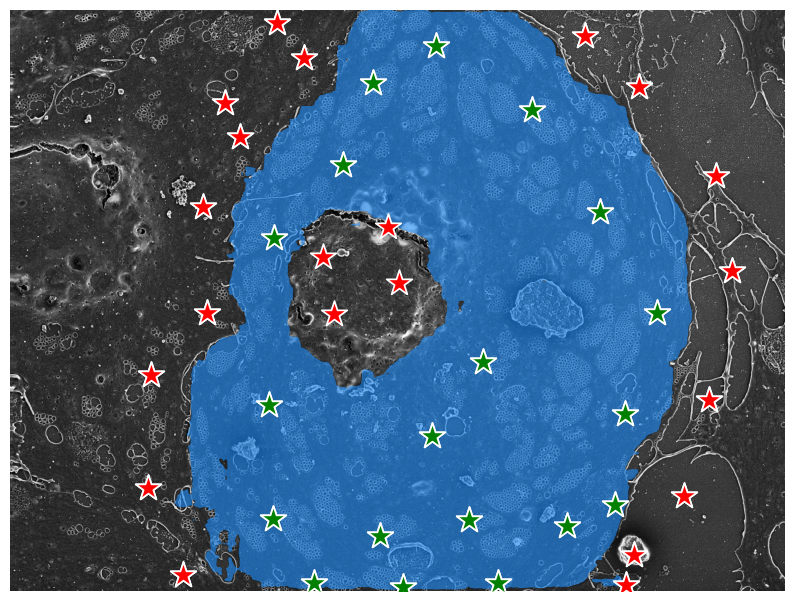

In [ ]:
w_container